# REMB Production Algorithm - DWG/DXF Support
    
Complete solution with:
- **DWG to DXF conversion** via ODA/LibreDWG
- **GPU Acceleration** via OR-Tools  
- **DXF Input/Output** with data preservation
- **File Upload** for Colab


In [1]:
# 0. INSTALL DEPENDENCIES
!pip install shapely matplotlib networkx ortools scikit-learn scipy numpy ezdxf

# Install LibreDWG for DWG conversion (Linux/Colab)
import platform
if platform.system() == 'Linux':
    !apt-get update -qq && apt-get install -y -qq libredwg-tools
    print("✅ LibreDWG installed for DWG conversion")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
grpcio-stat

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package libredwg-tools
✅ LibreDWG installed for DWG conversion


In [2]:
# 1. IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon, LineString, MultiLineString
from shapely.ops import unary_union, voronoi_diagram
import networkx as nx
from ortools.sat.python import cp_model
from sklearn.cluster import KMeans
import random, math, os, json, subprocess, shutil
from datetime import datetime
print("✅ All imports successful")


✅ All imports successful


In [3]:
# 2. CONFIGURATION (TCVN Standards)
ROAD_MAIN_WIDTH = 30.0
ROAD_INTERNAL_WIDTH = 15.0
SIDEWALK_WIDTH = 4.0
TURNING_RADIUS = 15.0
SERVICE_AREA_RATIO = 0.10
MIN_BLOCK_AREA = 5000
SETBACK_DISTANCE = 6.0
MIN_LOT_WIDTH, MAX_LOT_WIDTH, TARGET_LOT_WIDTH = 20.0, 80.0, 40.0
SOLVER_TIME_LIMIT = 2.0
USE_GPU = True
TRANSFORMER_RADIUS = 300
print("✅ Configuration loaded")


✅ Configuration loaded


In [4]:
# 3. GPU DETECTION
def check_gpu():
    try:
        import ctypes
        try: ctypes.CDLL("libcuda.so.1"); return True
        except:
            try: ctypes.CDLL("nvcuda.dll"); return True
            except: return False
    except: return False

GPU_AVAILABLE = check_gpu()
NUM_WORKERS = os.cpu_count() or 4
print(f"{'✅ GPU detected' if GPU_AVAILABLE else '⚠️ CPU mode'} - Workers: {NUM_WORKERS}")


⚠️ CPU mode - Workers: 2


In [5]:
# 4. DWG TO DXF CONVERTER
def convert_dwg_to_dxf(dwg_path, output_path=None):
    """Convert DWG to DXF using LibreDWG or ODA."""
    if output_path is None:
        output_path = os.path.splitext(dwg_path)[0] + ".dxf"

    try:
        # Try LibreDWG first
        result = subprocess.run(["dwg2dxf", "-o", output_path, dwg_path],
                                capture_output=True, text=True, timeout=60)
        if result.returncode == 0 and os.path.exists(output_path):
            print(f"✅ DWG converted: {output_path}")
            return output_path
    except: pass

    # LibreDWG not available
    print(f"⚠️ DWG conversion not available. Please convert {dwg_path} to DXF manually.")
    print("   Online tools: https://cloudconvert.com/dwg-to-dxf")
    return None

print("✅ DWG converter ready")


✅ DWG converter ready


## 📁 Upload DWG/DXF File

In [15]:
# 5. FILE UPLOAD
DXF_PATH = None
original_doc = None

try:
    from google.colab import files
    print("📁 Upload your DWG or DXF file:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.lower().endswith('.dwg'):
            print(f"🔄 Converting DWG: {filename}")
            DXF_PATH = convert_dwg_to_dxf(filename)
        elif filename.lower().endswith('.dxf'):
            DXF_PATH = filename
            print(f"✅ DXF loaded: {filename}")
        else:
            print(f"⚠️ Unsupported: {filename}")
except ImportError:
    print("ℹ️ Not in Colab. Set DXF_PATH manually.")
except:
    print("ℹ️ No file uploaded. Using random site.")

print(f"📍 DXF_PATH = {DXF_PATH}")


📁 Upload your DWG or DXF file:


Saving 7 july 2012.dxf to 7 july 2012.dxf
✅ DXF loaded: 7 july 2012.dxf
📍 DXF_PATH = 7 july 2012.dxf


✅ Boundary loaded: 9.20 ha
Site: 9.20 ha


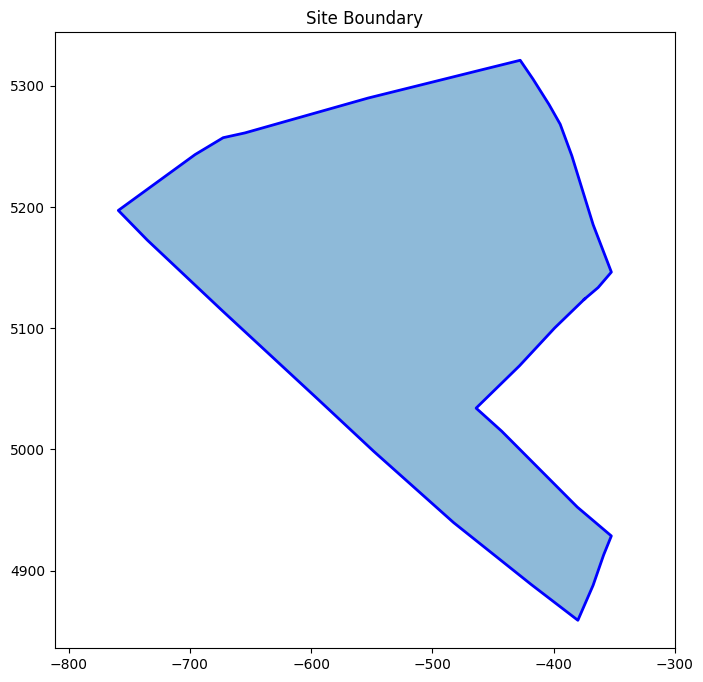

In [16]:
# 6. LOAD BOUNDARY
def load_boundary_from_dxf(dxf_path):
    try:
        import ezdxf
        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()
        largest = None
        max_area = 0
        for e in msp:
            if e.dxftype() == 'LWPOLYLINE' and e.is_closed:
                pts = list(e.get_points(format='xy'))
                if len(pts) >= 3:
                    poly = Polygon(pts)
                    if poly.is_valid and poly.area > max_area:
                        max_area = poly.area
                        largest = poly
        if largest:
            print(f"✅ Boundary loaded: {largest.area/10000:.2f} ha")
            return largest, doc
    except Exception as e:
        print(f"❌ Error: {e}")
    return None, None

def create_random_site():
    angles = np.sort(np.random.rand(8) * 2 * np.pi)
    radii = 400 + np.random.rand(8) * 200
    return Polygon(np.c_[radii * np.cos(angles), radii * np.sin(angles)])

def get_elevation(x, y):
    return 50.0 - (x * 0.02) - (y * 0.03)

if DXF_PATH and os.path.exists(DXF_PATH):
    site_polygon, original_doc = load_boundary_from_dxf(DXF_PATH)
    if site_polygon is None:
        site_polygon = create_random_site()
else:
    site_polygon = create_random_site()
    print("ℹ️ Using random site")

minx, miny, maxx, maxy = site_polygon.bounds
print(f"Site: {site_polygon.area/10000:.2f} ha")

plt.figure(figsize=(8,8))
x,y = site_polygon.exterior.xy
plt.fill(x,y,alpha=0.5)
plt.plot(x,y,'b-',lw=2)
plt.axis('equal')
plt.title("Site Boundary")
plt.show()


In [17]:
# 7. ROAD NETWORK
def generate_road_network(site, num_seeds=15):
    minx,miny,maxx,maxy = site.bounds
    regions = voronoi_diagram(MultiPolygon([site.buffer(100)]), envelope=site.buffer(200))
    edges = []
    if hasattr(regions,'geoms'):
        for r in regions.geoms:
            if r.geom_type=='Polygon': edges.append(r.exterior)
    center = site.centroid
    road_polys = []
    merged = unary_union(edges)
    for line in (list(merged.geoms) if hasattr(merged,'geoms') else [merged]):
        if not isinstance(line, LineString): continue
        w = (ROAD_MAIN_WIDTH if line.distance(center)<100 or line.length>400 else ROAD_INTERNAL_WIDTH) + 2*SIDEWALK_WIDTH
        road_polys.append(line.buffer(w/2, cap_style=2, join_style=2))
    if not road_polys: return [],[],Polygon()
    network = unary_union(road_polys)
    smooth = network.buffer(TURNING_RADIUS,join_style=1).buffer(-TURNING_RADIUS,join_style=1)
    blocks_rough = site.difference(smooth)
    cands = list(blocks_rough.geoms) if hasattr(blocks_rough,'geoms') else ([blocks_rough] if blocks_rough.geom_type=='Polygon' else [])
    cands.sort(key=lambda b: get_elevation(b.centroid.x, b.centroid.y))
    service, commercial = [], []
    total = sum(b.area for b in cands)
    curr_svc = 0
    if cands:
        w = cands.pop(0)
        service.append({'geom':w,'type':'XLNT'})
        curr_svc += w.area
    for b in cands:
        if curr_svc < total*SERVICE_AREA_RATIO or b.area < MIN_BLOCK_AREA:
            service.append({'geom':b,'type':'Admin'})
            curr_svc += b.area
        else: commercial.append(b)
    return commercial, service, smooth

blocks, service_blocks, road_network = generate_road_network(site_polygon)
print(f"✅ Blocks: {len(blocks)} commercial, {len(service_blocks)} service")


✅ Blocks: 0 commercial, 3 service


In [18]:
# 8. LOT SUBDIVISION (GPU)
def solve_subdivision(total_len, min_w, max_w, target_w):
    model = cp_model.CpModel()
    max_lots = int(total_len // min_w) + 2
    widths, active, diffs = [], [], []
    for i in range(max_lots):
        w = model.NewIntVar(0, int(max_w*10), f'w_{i}')
        a = model.NewBoolVar(f'a_{i}')
        model.Add(w >= int(min_w*10)).OnlyEnforceIf(a)
        model.Add(w <= int(max_w*10)).OnlyEnforceIf(a)
        model.Add(w == 0).OnlyEnforceIf(a.Not())
        d = model.NewIntVar(0, int(max_w*10), f'd_{i}')
        model.Add(d >= w - int(target_w*10)).OnlyEnforceIf(a)
        model.Add(d >= int(target_w*10) - w).OnlyEnforceIf(a)
        model.Add(d == 0).OnlyEnforceIf(a.Not())
        widths.append(w); active.append(a); diffs.append(d)
    total_w = model.NewIntVar(0, int(total_len*10), 'total')
    model.Add(total_w == sum(widths))
    model.Maximize(total_w*100 - sum(diffs))
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = SOLVER_TIME_LIMIT
    if GPU_AVAILABLE:
        solver.parameters.num_workers = 0
    else:
        solver.parameters.num_workers = NUM_WORKERS
    solver.Solve(model)
    return [solver.Value(widths[i])/10.0 for i in range(max_lots) if solver.Value(active[i])]

final_lots = []
print("🔄 Subdividing lots...")
for block in blocks:
    rect = block.minimum_rotated_rectangle
    x,y = rect.exterior.coords.xy
    lens = [Point(x[i],y[i]).distance(Point(x[i+1],y[i+1])) for i in range(4)]
    idx = np.argmax(lens)
    ws = solve_subdivision(lens[idx], MIN_LOT_WIDTH, MAX_LOT_WIDTH, TARGET_LOT_WIDTH)
    p0 = np.array([x[idx],y[idx]])
    p1 = np.array([x[(idx+1)%4],y[(idx+1)%4]])
    vec = p1-p0
    vlen = np.linalg.norm(vec)
    if vlen == 0: continue
    uv = vec/vlen
    ort = np.array([-uv[1],uv[0]])
    curr = 0
    for w in ws:
        st = p0 + uv*curr
        en = p0 + uv*(curr+w)
        cutter = Polygon([st-ort*500,en-ort*500,en+ort*500,st+ort*500])
        lot = block.intersection(cutter)
        if not lot.is_empty and lot.area > 500:
            if isinstance(lot, MultiPolygon):
                for g in lot.geoms: final_lots.append(g)
            else: final_lots.append(lot)
        curr += w

processed_lots = []
for lot in final_lots:
    ba = lot.buffer(-SETBACK_DISTANCE)
    if not ba.is_empty:
        dens = 0.7 if lot.area < 3000 else (0.65 if lot.area < 10000 else 0.6)
        processed_lots.append({'geom':lot,'buildable':ba,'density':dens*100,'max_area':lot.area*dens})
print(f"✅ Generated {len(processed_lots)} lots")


🔄 Subdividing lots...
✅ Generated 0 lots


In [19]:
# 9. INFRASTRUCTURE (KeyError FIXED)
def create_loop_network(lots):
    if not lots: return nx.Graph(), {}
    centroids = [l['geom'].centroid for l in lots]
    G = nx.Graph()
    for i,p in enumerate(centroids): G.add_node(i, pos=(p.x,p.y))
    for i in range(len(centroids)):
        for j in range(i+1,len(centroids)):
            d = centroids[i].distance(centroids[j])
            if d < 150: G.add_edge(i,j,weight=d)
    if not nx.is_connected(G) and len(G.nodes())>0:
        comps = list(nx.connected_components(G))
        if comps: G = G.subgraph(max(comps,key=len)).copy()
    if len(G.edges())>0:
        mst = nx.minimum_spanning_tree(G)
        loop = mst.copy()
        for u,v,d in sorted(G.edges(data=True),key=lambda x:x[2].get('weight',0)):
            if not loop.has_edge(u,v):
                loop.add_edge(u,v,weight=d.get('weight',0))
                if len(loop.edges()) >= len(mst.edges()) + max(1,int(len(G.nodes())*0.15)): break
    else: loop = G
    # CRITICAL FIX: Build pos from ACTUAL graph nodes
    pos = {n:(centroids[n].x,centroids[n].y) for n in loop.nodes() if n < len(centroids)}
    return loop, pos

print("🔄 Infrastructure...")
infra_graph, infra_pos = create_loop_network(processed_lots) if processed_lots else (nx.Graph(),{})
transformer_locs = np.array([])
if processed_lots:
    coords = np.array([[l['geom'].centroid.x,l['geom'].centroid.y] for l in processed_lots])
    nt = min(max(1,len(processed_lots)//15), len(processed_lots))
    transformer_locs = KMeans(n_clusters=nt,n_init=10,random_state=42).fit(coords).cluster_centers_
print(f"✅ Transformers: {len(transformer_locs)}, Grid: {len(infra_graph.nodes())} nodes")


🔄 Infrastructure...
✅ Transformers: 0, Grid: 0 nodes


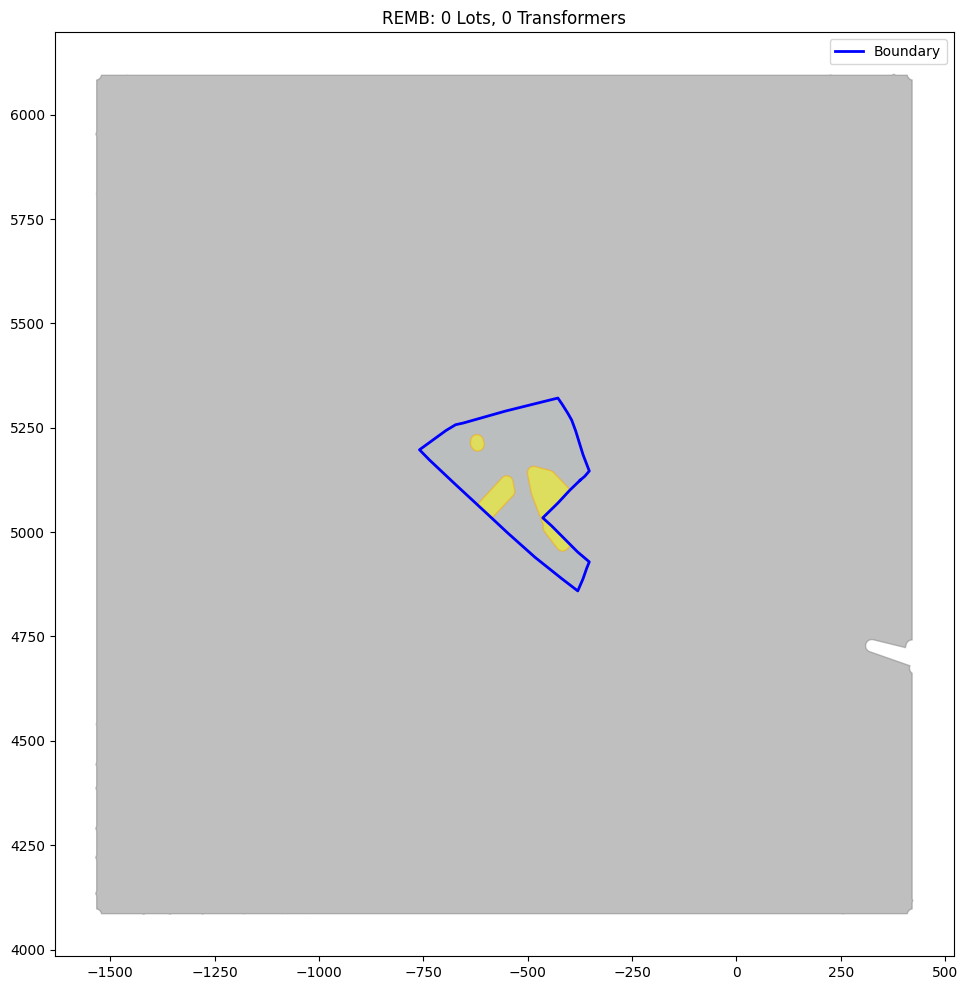

✅ Visualization complete


In [20]:
# 10. VISUALIZATION
fig, ax = plt.subplots(figsize=(12,12))
x,y = site_polygon.exterior.xy
ax.fill(x,y,color='#e0f7fa',alpha=0.2)
ax.plot(x,y,'b-',lw=2,label='Boundary')
if road_network and not road_network.is_empty:
    for g in (road_network.geoms if hasattr(road_network,'geoms') else [road_network]):
        x,y = g.exterior.xy
        ax.fill(x,y,color='gray',alpha=0.5)
for lot in processed_lots:
    x,y = lot['geom'].exterior.xy
    ax.fill(x,y,color='lightgreen',alpha=0.6,ec='green',lw=1)
for sb in service_blocks:
    x,y = sb['geom'].exterior.xy
    ax.fill(x,y,color='yellow',alpha=0.5,ec='orange',lw=1)
for u,v in infra_graph.edges():
    if u in infra_pos and v in infra_pos:
        ax.plot([infra_pos[u][0],infra_pos[v][0]],[infra_pos[u][1],infra_pos[v][1]],'b-',lw=0.5,alpha=0.3)
if len(transformer_locs)>0:
    ax.scatter(transformer_locs[:,0],transformer_locs[:,1],s=200,c='red',marker='s',zorder=10,label='Transformers')
ax.set_title(f"REMB: {len(processed_lots)} Lots, {len(transformer_locs)} Transformers")
ax.legend()
ax.set_aspect('equal')
plt.show()
print("✅ Visualization complete")


In [21]:
# 11. JSON OUTPUT
result = {
    "timestamp": datetime.now().isoformat(),
    "site_area_ha": site_polygon.area/10000,
    "gpu_used": GPU_AVAILABLE,
    "lots": [{"id":i+1,"x":l['geom'].centroid.x,"y":l['geom'].centroid.y,"area":l['geom'].area,"density":l['density']} for i,l in enumerate(processed_lots)],
    "transformers": [{"id":i+1,"x":float(t[0]),"y":float(t[1])} for i,t in enumerate(transformer_locs)]
}
with open('optimization_result.json','w') as f: json.dump(result,f,indent=2)
print(f"✅ JSON saved: {len(result['lots'])} lots, {len(result['transformers'])} transformers")


✅ JSON saved: 0 lots, 0 transformers


In [22]:
# 12. DXF EXPORT
import ezdxf
def export_dxf(path, orig_doc=None):
    doc = orig_doc if orig_doc else ezdxf.new('R2010')
    msp = doc.modelspace()
    for lyr,col in [('OPTIMIZED_PLOTS',3),('ANNOTATIONS',7),('INFRASTRUCTURE',5)]:
        if lyr not in doc.layers: doc.layers.add(lyr,color=col)
    for i,lot in enumerate(processed_lots):
        msp.add_lwpolyline(list(lot['geom'].exterior.coords),close=True,dxfattribs={'layer':'OPTIMIZED_PLOTS'})
        c = lot['geom'].centroid
        msp.add_text(f"P{i+1}",dxfattribs={'layer':'ANNOTATIONS','height':5,'insert':(c.x,c.y)})
    for i,t in enumerate(transformer_locs):
        msp.add_circle((float(t[0]),float(t[1])),10,dxfattribs={'layer':'INFRASTRUCTURE'})
    doc.saveas(path)
    print(f"✅ DXF: {path}")
    return path

export_dxf('remb_output.dxf', original_doc)


✅ DXF: remb_output.dxf


'remb_output.dxf'

In [23]:
# 13. DOWNLOAD
try:
    from google.colab import files
    for f in ['optimization_result.json','remb_output.dxf']:
        if os.path.exists(f): files.download(f); print(f"📥 {f}")
    print("🎉 Done!")
except: print("ℹ️ Files in current directory")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 optimization_result.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 remb_output.dxf
🎉 Done!
